# [Image compression](https://en.wikipedia.org/wiki/Image_compression) by k-means clustering


### [3-channel (RGB) color images](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images ) in 24-bit color representation allows for more than 16 million ($2^{24}$) different colors. In the computer, an RGB image is stored as a stack of (3) matrices, hence each pixel of the image is a 3-dimensional vector reflecting the mixture of the colors Red, Green and Blue:


![Loss](RGB.jpg)

### By doing k-means clustering of the 3-dimensional (RGB) pixel vectors, we can find just a few (k) useful color combinations (the resulting cluster centers) to replace the original pixel vectors in a compressed version of the image.

### See also the [VMLS k-means notes](http://stanford.edu/class/ee103/lectures/k-means_slides.pdf) on clustering applications.


# Candidate color imagees for doing pixel-clustering


![Loss](spacex-launch-why-starman-tesla-roadster-david-bowie-falcon-heavy-1225205.jpg)
![Loss](Everyones_a_little_bit_racist_sometimes.jpg)
![Loss](c=1114,366,1920,1048.jpg)


In [17]:
# import Pkg; Pkg.add("Images"); Pkg.add("ImageMagick")
# import Pkg; Pkg.add("HTTP")
using Images # Image loading, saving, manipulation
using HTTP   # Internet access

In [18]:
using Plots # Precompiles on every startup (~20 secondss)
gr() # Needs modules Plots and GR to be installed, may need a rebuild of GR with ']build GR'
default(size=(600, 450), fmt = :png) # Default plot size, change output format to png

##  Load an image either locally or from the internet

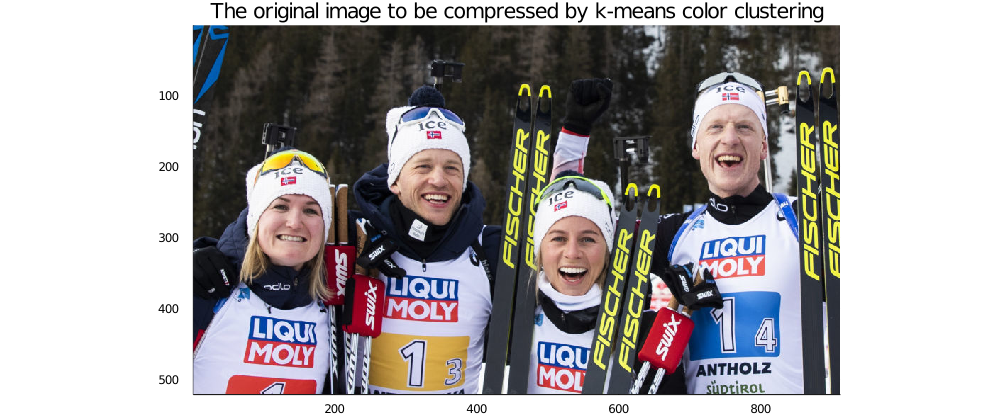

In [19]:
# Load image stored on a local folder adress:
# myimage = "C:/Users/ulfin/Dropbox/MATH310/Forelesninger_2021/Clustering/Everyones_a_little_bit_racist_sometimes.jpg";
# Ximg = load(myimage);

# Load image from the Internet:
# ---------------------------------
#imageadress = "https://cdn.images.express.co.uk/img/dynamic/151/590x/secondary/spacex-launch-why-starman-tesla-roadster-david-bowie-falcon-heavy-1225205.jpg";
#imageadress = "http://pressarchive.theoldglobe.org/_img/pressphotos/pre2008%20photos/aveQ5.jpg";
#imageadress = "https://vgc.no/drfront/images/2018/02/12/c=1114,366,1920,1048;w=262;h=143;384858.jpg";
imageadress = "https://www.dagbladet.no/images/73342156.jpg?imageId=73342156&x=15.602322206096&y=10.807860262009&cropw=72.060957910015&croph=61.764705882353&width=912&height=521&compression=80";
# -------------------------b--------
#imageadress = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png";
#imageadress = "http://www.johnloomis.org/ece563/notes/basics/components/mandrill/Mandrill.jpg";
# ---------------------------------
                                 # download("http://pressarchive.theoldglobe.org/_img/pressphotos/pre2008%20photos/aveQ5.jpg", "myimage.png"); Ximg = load("myimage.png");
myimage = download(imageadress); # Needs package ImageMagick
Ximg = load(myimage);

original = plot(Ximg, title = string("The original image to be compressed by k-means color clustering"), size = (1000,420))
display(original)

In [20]:
# Find image size and prepare to reshape the pixel-data for clustering
n,m = size(Ximg); 
nm = n*m


475152

###  We make a three-column matrix X where each row is an RGB-vector of a pixel position in the original image 

In [21]:
mat = channelview(Ximg); # Convert from image format to 3 x n x m (0-1).
X = float( reshape( permutedims(mat, (2,3,1)), (nm, 3) ) ); # Channels last, vectorize image dims, convert to float

### Now we can cluster the RGB-vectors of the pixels in X

In [22]:
include("mykmeans.jl")
## Cluster RGB-pixel values (in X) into k color clusters by the k-means algorithm
k = 64; # The number of clusters

@time begin
Cid, Ccenters, J, cs = mykmeans(X,k); # This will take some time...
                                    # Cid:      a vector of cluster labels for the rows in X.
                                    # Ccenters: the resulting k cluster centers.     
                                    # J:        the clustering objective function values
                                    # cs:       the cluster sizes (number of members in each cluster)

#Cs = uint8(Ccenters); # Convert cluster centers into uint8-format
end

14971.600851 seconds (1.70 G allocations: 165.849 GiB, 49.16% gc time)

([31; 30; … ; 42; 8], Float32[0.26576123 0.25057808 0.21686858; 0.16428317 0.1536433 0.122312665; … ; 0.7762253 0.7893071 0.8854132; 0.7081954 0.7268821 0.8349314], Any[0.006814382045102717, 0.004148015567724364, 0.0037858568030863346, 0.0035675349248211786, 0.0033794008715212214, 0.003158606448861204, 0.0029964163555941115, 0.00291535318730639, 0.0028767928077991414, 0.0028504343597313027  …  0.0026668494270245427, 0.002648549767558303, 0.0026328685731197266, 0.002617474822949762, 0.0025987452285090033, 0.002573929928778632, 0.00253726438117371, 0.002507538545136637, 0.0024937143317414123, 0.002483784547290244], [8699.0; 14974.0; … ; 12344.0; 8131.0])

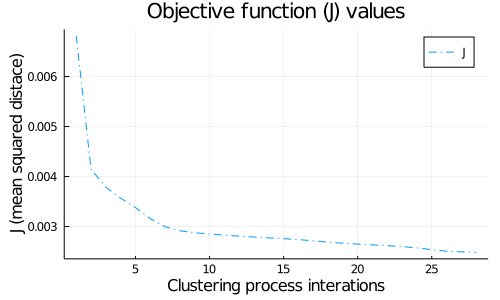

In [23]:
# Plotting the objective function values reflecting the clustering process
Jplot = plot(J, linestyle = :dashdot, title = "Objective function (J) values", 
    ylabel = "J (mean squared distace)", xlabel = "Clustering process interations", label = "J", size = (500, 300))
display(Jplot)

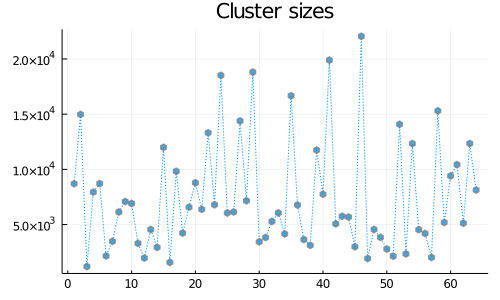

In [24]:
# Plotting the cluster sizes:
csplot = plot(cs, line = (:dot, 1), marker = ([:hex :d], 3, 0.8, Plots.stroke(3, :gray)), title = "Cluster sizes", label = "", size = (500, 300))
display(csplot)

### Reshape and display cluster labels as associated image

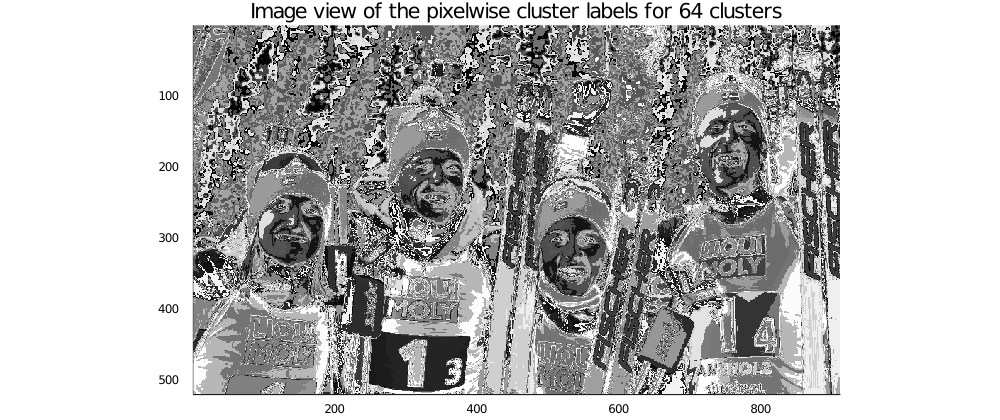

In [25]:
cl = reshape(Cid,(n,m)); # cl is an image (n x m - matrix) viewing the cluster labels
#print(string("Image view of the cluster labels for ", k, " clusters"))
#Gray.(cl/k)
labelplot = plot(Gray.(cl/k), title = string("Image view of the pixelwise cluster labels for ", k, " clusters"), size = (1000,420))
display(labelplot)

### Show the compressed image by inserting the (k) cluster center vectors to display the colors

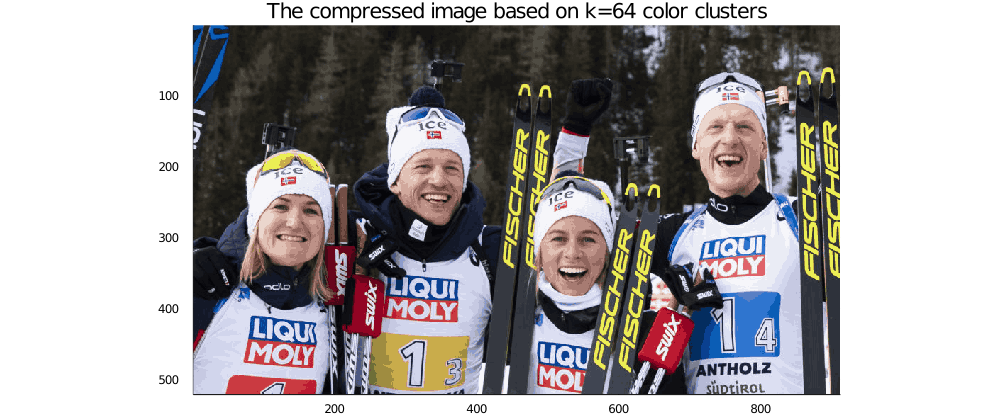

In [26]:
# print(string("The compressed image based on k=", k, " color clusters"))
# Use cluster-IDs (Cid) as lookup in cluster centers (Ccenters), reshape, permute and convert to RGB
# colorview(RGB, permutedims( reshape(Ccenters[Cid,:],(n, m, 3)), (3,1,2)))
cmpplot = plot(colorview(RGB, permutedims( reshape(Ccenters[Cid,:],(n, m, 3)), (3,1,2))), title = string("The compressed image based on k=", k, " color clusters"), size = (1000,420))
display(cmpplot)

### The residual image (difference between original and compressed images based on the clustering)

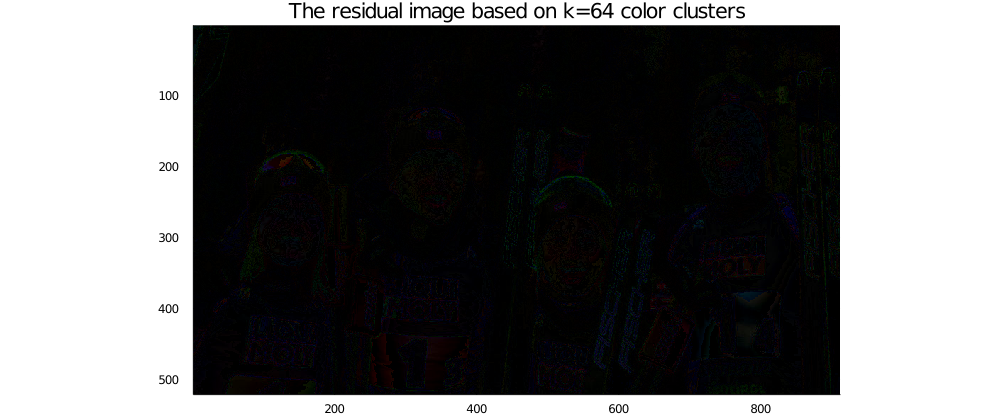

In [27]:
#print(string("The residual image based on k=", k, " color clusters"))
#Ximg - colorview(RGB, permutedims( reshape(Ccenters[Cid,:],(n, m, 3)), (3,1,2)))
resplot = plot(Ximg-colorview(RGB, permutedims( reshape(Ccenters[Cid,:],(n, m, 3)), (3,1,2))), title = string("The residual image based on k=", k, " color clusters"), size = (1000,420))
display(resplot)